In [11]:
!rm -rf gm-hw3
!git clone https://github.com/shankarp8/gm-hw3.git
!wget https://courses.cs.washington.edu/courses/cse599i/20au/resources/hw3data.tar.gz
!tar -xf hw3data.tar.gz

Cloning into 'gm-hw3'...
remote: Enumerating objects: 68, done.
remote: Counting objects: 100% (68/68), done.
remote: Compressing objects: 100% (61/61), done.
remote: Total 68 (delta 38), reused 17 (delta 7), pack-reused 0 (from 0)
Receiving objects: 100% (68/68), 22.26 MiB | 40.79 MiB/s, done.
Resolving deltas: 100% (38/38), done.
--2025-04-26 22:15:33--  https://courses.cs.washington.edu/courses/cse599i/20au/resources/hw3data.tar.gz
Resolving courses.cs.washington.edu (courses.cs.washington.edu)... 128.208.1.193, 2607:4000:200:10::c1
Connecting to courses.cs.washington.edu (courses.cs.washington.edu)|128.208.1.193|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 182109015 (174M) [application/x-gzip]
Saving to: ‘hw3data.tar.gz.1’

hw3data.tar.gz.1    100%[===================>] 173.67M  12.5MB/s    in 12s     

2025-04-26 22:15:46 (14.2 MB/s) - ‘hw3data.tar.gz.1’ saved [182109015/182109015]



In [12]:
import sys,os,signal
from time import time

import numpy as np

import matplotlib
import matplotlib.pyplot as plt

import torch
from torch import Tensor
from torchvision import transforms

from IPython import display

sys.path.append('./gm-hw3')
import importlib
importlib.reload(mnist)
importlib.reload(models)
importlib.reload(utils)
importlib.reload(inception)

root = 'data/'

In [13]:
def worker_init(args):
    signal.signal(signal.SIGINT, signal.SIG_IGN)

batch_size = 256
kwargs = {'num_workers': 2, 'pin_memory': True, 'worker_init_fn': worker_init}

train_set = cifar.CIFAR10(root=root, train=True, one_hot=True, transform=transforms.ToTensor(),download=True)
test_set = cifar.CIFAR10(root=root, train=False, one_hot=True, transform=transforms.ToTensor())

train_loader = torch.utils.data.DataLoader(dataset=train_set,batch_size=batch_size,shuffle=True, **kwargs)
test_loader = torch.utils.data.DataLoader(dataset=test_set,batch_size=batch_size,shuffle=False, **kwargs)

Files already downloaded and verified


In [14]:
seed_size = 128

g = models.GeneratorCIFAR(seed_size).cuda()
f = models.DiscriminatorCIFAR().cuda()

AttributeError: module 'models' has no attribute 'Generator'

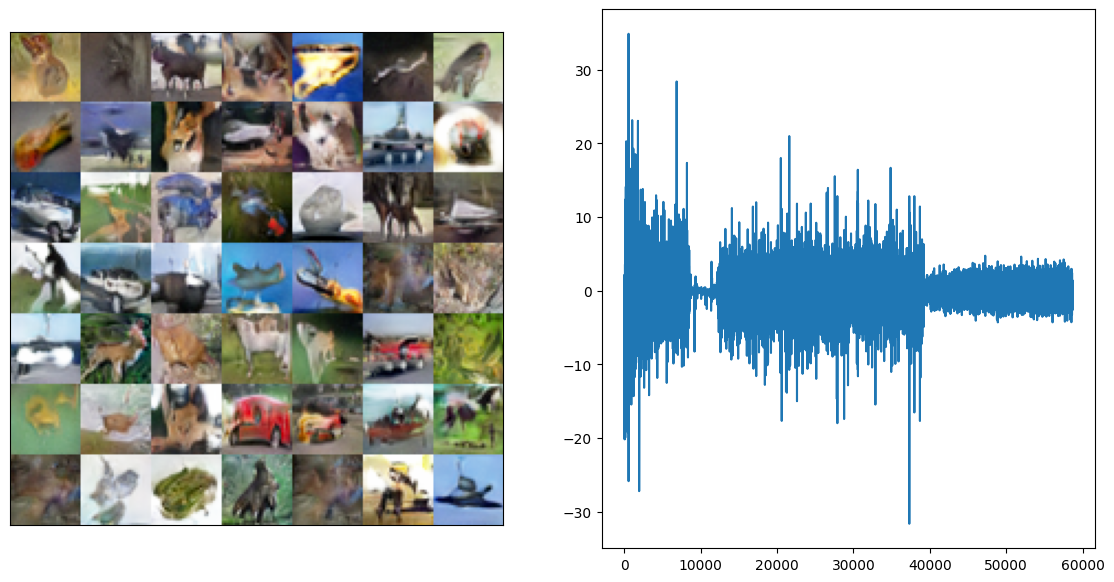

58700 16.222421884536743 7.898345


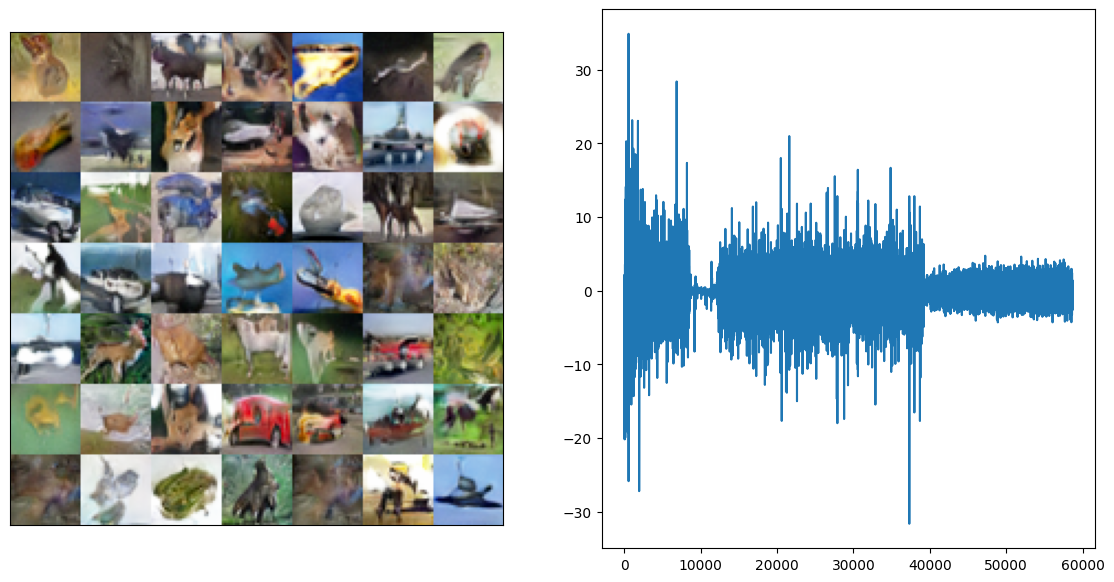

In [ ]:
fig, ax = plt.subplots(1,2,figsize=(14,7))

lr = 3e-4

foptimizer = torch.optim.Adam(f.parameters(), lr=lr, betas=(0.0,0.9))
goptimizer = torch.optim.Adam(g.parameters(), lr=lr, betas=(0.0,0.9))

losses = []

i = 0
t0 = time()
scores = []
epochs = 100
for epoch in range(epochs):
    for x,_ in train_loader:
        x = x.cuda()

        #
        # Problem 6: Calculate gan updates. You ought to be able to
        # use the same code that you implemented and debugged for MNIST.
        #
        # Track your generator loss by appending its loss to losses.
        #
        #
        foptimizer.zero_grad()

        z = torch.randn(x.size(0), seed_size).cuda()
        temp = g(z).detach() # detach so that gradients aren't propped. to generator when discrim. is updated

        score = f(x)
        temp_score = f(temp)

        eps = torch.randn(x.size(0), 1, 1, 1).cuda()
        interp = eps * x + (1 - eps) * temp
        interp = interp.requires_grad_()
        new_score = f(interp)

        grad = torch.autograd.grad(outputs=new_score, inputs=interp, grad_outputs=torch.ones_like(new_score), create_graph=True, retain_graph=True, only_inputs=True)[0]
        grad_norm = grad.view(grad.size(0), -1).norm(2, dim=1)
        pen = ((grad_norm - 1) ** 2).mean()

        lambda_val = 10
        discrim_loss = temp_score.mean() - score.mean() + lambda_val * pen
        discrim_loss.backward()
        foptimizer.step()

        goptimizer.zero_grad()

        z = torch.randn(x.size(0), seed_size).cuda()
        generated = g(z)
        loss = -f(generated).mean()
        loss.backward()
        goptimizer.step()

        losses.append(loss.detach().cpu().numpy())

        if i % 100 == 0:
            g.eval()
            y = g(torch.randn(batch_size, seed_size).cuda())
            display.clear_output(wait=True)
            utils.print_images(y.detach().cpu().numpy(), ax[0])
            ax[1].cla(); ax[1].plot(losses)
            display.display(plt.gcf())
            scores.append(inception.score(g, 1000, 100))
            print(i, time()-t0, scores[-1])
            g.train()
            t0 = time()
        i += 1

Final inception score: 8.095841


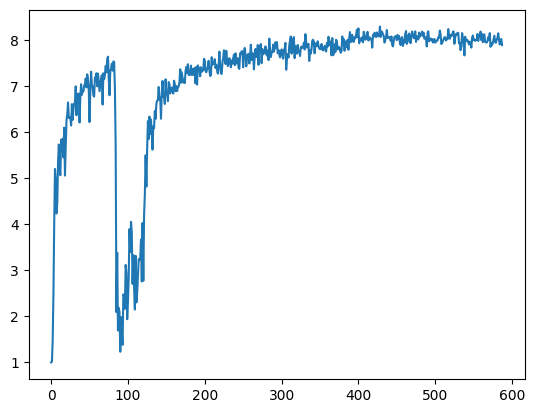

In [10]:
plt.plot(scores)

g.eval()
print("Final inception score:", inception.score(g, 50000, 100))
g.train();